# Few-Shot Weight Optimization: BMC_OR <-> BMC_Red Transfer

This notebook implements Weight Optimization with Few-Shot Learning using mixed datasets to transfer knowledge between Orange juice (BMC_OR) and Red juice (BMC_Red) measuring cup models.

**Key Approach (from Devson Butani's thesis):**
- Use ES(N+M) to directly optimize neural network weights (no backpropagation)
- Mixed datasets: Few-shot target + original domain samples to prevent catastrophic forgetting
- 1/5 Success Rule for adaptive step size

**Transfer Directions:**
1. Orange Model → Red Prediction (using FSR_mixed: 50 Red + 15 Orange)
2. Red Model → Orange Prediction (using FSO_mixed: 50 Orange + 15 Red)

## Cell 1: Imports and Setup

In [11]:
import os
import time
import random
import copy
import json
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

START_TIME = time.time()

PyTorch version: 2.1.0+cu121
Using device: cuda
GPU: NVIDIA A100 80GB PCIe


## Cell 2: Configuration

In [12]:
CONFIG = {
    # Dataset paths
    'or_train_path': '/data1/Siri/MeasuringCup/BMC_OR/OR_training',
    'or_test_path': '/data1/Siri/MeasuringCup/BMC_OR/OR_testing',
    'red_train_path': '/data1/Siri/MeasuringCup/BMC_Red/Red_Training',
    'red_test_path': '/data1/Siri/MeasuringCup/BMC_Red/Red_Testing',
    
    # Pre-trained model paths
    'or_model_path': '/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_es_optimized.pth',
    'red_model_path': '/data1/Siri/MeasuringCup/BMC_Red/Red_code/Red_ES_1plus1_best.pth',
    
    # Few-shot dataset sizes
    'fs_size': 50,           # Few-shot images from target domain
    'mixed_size': 15,        # Images from original domain to prevent forgetting
    
    # ES parameters
    'max_generations': 100,
    'initial_step_size': 0.01,  # Small step for pre-trained weights
    'step_ratio': 0.82,          # 1/5 rule adaptation factor
    'window_size': 5,            # Success rate tracking window
    'tolerance': 5.0,            # MAE threshold for early stopping (< 5)
    
    # N,M pairs to test
    'nm_pairs': [(4, 4), (10, 80)],
    
    # Image settings
    'img_size': 224,
    'batch_size': 32,
    
    # Output directory
    'output_dir': '/data1/Siri/MeasuringCup/Final_codefiles/FS_results',
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Configuration:")
for key, val in CONFIG.items():
    print(f"  {key}: {val}")

Configuration:
  or_train_path: /data1/Siri/MeasuringCup/BMC_OR/OR_training
  or_test_path: /data1/Siri/MeasuringCup/BMC_OR/OR_testing
  red_train_path: /data1/Siri/MeasuringCup/BMC_Red/Red_Training
  red_test_path: /data1/Siri/MeasuringCup/BMC_Red/Red_Testing
  or_model_path: /data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_es_optimized.pth
  red_model_path: /data1/Siri/MeasuringCup/BMC_Red/Red_code/Red_ES_1plus1_best.pth
  fs_size: 50
  mixed_size: 15
  max_generations: 100
  initial_step_size: 0.01
  step_ratio: 0.82
  window_size: 5
  tolerance: 5.0
  nm_pairs: [(4, 4), (10, 80)]
  img_size: 224
  batch_size: 32
  output_dir: /data1/Siri/MeasuringCup/Final_codefiles/FS_results


## Cell 3: Model Architecture Definition

**IMPORTANT:** Must match the architecture used in training for weight loading to work.

In [13]:
class ResNet50Regressor(nn.Module):
    """ResNet50 with custom regression head for volume prediction.
    
    Architecture matches OR_Resnet50_ES.ipynb for weight compatibility.
    """
    def __init__(self, dropout_1=0.4, dropout_2=0.2, hidden_units=256, freeze_ratio=0.4):
        super().__init__()
        
        # Load pretrained ResNet50
        self.base = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze layers based on freeze_ratio
        all_params = list(self.base.parameters())
        freeze_point = int(len(all_params) * freeze_ratio)
        for i, param in enumerate(all_params):
            param.requires_grad = (i >= freeze_point)
        
        # Get feature dimension from fc layer
        in_features = self.base.fc.in_features
        
        # Replace fc with custom regression head
        self.base.fc = nn.Sequential(
            nn.Dropout(dropout_1),
            nn.Linear(in_features, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_2),
            nn.Linear(hidden_units, 1)
        )
    
    def forward(self, x):
        return self.base(x).squeeze(-1)


def get_hidden_units_from_state_dict(state_dict_path):
    """Detect hidden units from saved state dict.
    
    The fc.1.weight tensor has shape [hidden_units, 2048],
    so we can detect the hidden_units from the first dimension.
    """
    state_dict = torch.load(state_dict_path, map_location='cpu')
    # Look for fc.1.weight shape - it's [hidden_units, 2048]
    for key, value in state_dict.items():
        if 'fc.1.weight' in key:
            return value.shape[0]
    return 256  # Default


def load_model_from_state_dict(state_dict_path, device):
    """Load model with correct architecture from state dict.
    
    Automatically detects hidden_units and creates matching architecture.
    """
    hidden_units = get_hidden_units_from_state_dict(state_dict_path)
    print(f"  Detected hidden_units: {hidden_units}")
    
    model = ResNet50Regressor(hidden_units=hidden_units).to(device)
    state_dict = torch.load(state_dict_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    return model, hidden_units


print("Model architectures and helper functions defined.")

Model architectures and helper functions defined.


## Cell 4: Data Loading Functions

In [14]:
def collect_images_or(base_folder):
    """Collect images from BMC_OR dataset (flat structure)."""
    X_paths = []
    Y = []
    
    for vol_name in sorted(os.listdir(base_folder)):
        if not vol_name.isdigit():
            continue
        vol_path = os.path.join(base_folder, vol_name)
        if not os.path.isdir(vol_path):
            continue
        
        for img_file in sorted(os.listdir(vol_path)):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                X_paths.append(os.path.join(vol_path, img_file))
                Y.append(int(vol_name))
    
    return X_paths, np.array(Y, dtype=np.float32)


def collect_images_red(base_folder):
    """Collect images from BMC_Red dataset (nested BV/FV subfolder structure)."""
    X_paths = []
    Y = []
    
    for vol_name in sorted(os.listdir(base_folder)):
        if not vol_name.isdigit():
            continue
        vol_path = os.path.join(base_folder, vol_name)
        if not os.path.isdir(vol_path):
            continue
        
        # Iterate through BV/FV subfolders
        for sub in sorted(os.listdir(vol_path)):
            sub_path = os.path.join(vol_path, sub)
            if not os.path.isdir(sub_path):
                continue
            for img_file in sorted(os.listdir(sub_path)):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    X_paths.append(os.path.join(sub_path, img_file))
                    Y.append(int(vol_name))
    
    return X_paths, np.array(Y, dtype=np.float32)


def load_images_torch(paths, target_size=(224, 224)):
    """Load and preprocess images for PyTorch with ImageNet normalization."""
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    X = []
    for p in paths:
        img = Image.open(p).convert('RGB')
        img_tensor = transform(img)
        X.append(img_tensor)
    
    return torch.stack(X)


print("Data loading functions defined.")

Data loading functions defined.


## Cell 5: Load All Datasets

In [15]:
print("="*60)
print("LOADING DATASETS")
print("="*60)

# Load BMC_OR (Orange) dataset
print("\nLoading BMC_OR (Orange) dataset...")
or_train_paths, or_train_labels = collect_images_or(CONFIG['or_train_path'])
or_test_paths, or_test_labels = collect_images_or(CONFIG['or_test_path'])
print(f"  Training: {len(or_train_paths)} images")
print(f"  Testing: {len(or_test_paths)} images")

# Load BMC_Red dataset
print("\nLoading BMC_Red dataset...")
red_train_paths, red_train_labels = collect_images_red(CONFIG['red_train_path'])
red_test_paths, red_test_labels = collect_images_red(CONFIG['red_test_path'])
print(f"  Training: {len(red_train_paths)} images")
print(f"  Testing: {len(red_test_paths)} images")

# Load test images into memory
print("\nLoading test images into memory...")
X_or_test = load_images_torch(or_test_paths, (CONFIG['img_size'], CONFIG['img_size']))
Y_or_test = torch.tensor(or_test_labels, dtype=torch.float32)
print(f"  OR test: {X_or_test.shape}")

X_red_test = load_images_torch(red_test_paths, (CONFIG['img_size'], CONFIG['img_size']))
Y_red_test = torch.tensor(red_test_labels, dtype=torch.float32)
print(f"  Red test: {X_red_test.shape}")

print("\nDatasets loaded successfully!")

LOADING DATASETS

Loading BMC_OR (Orange) dataset...
  Training: 794 images
  Testing: 107 images

Loading BMC_Red dataset...
  Training: 794 images
  Testing: 107 images

Loading test images into memory...
  OR test: torch.Size([107, 3, 224, 224])
  Red test: torch.Size([107, 3, 224, 224])

Datasets loaded successfully!


## Cell 6: Create Few-Shot Mixed Datasets

In [16]:
def create_fs_mixed_dataset(target_paths, target_labels, original_paths, original_labels,
                            fs_size=50, mixed_size=15):
    """Create a few-shot mixed dataset for transfer learning."""
    # Sample fs_size images from target domain
    target_indices = random.sample(range(len(target_paths)), min(fs_size, len(target_paths)))
    fs_paths = [target_paths[i] for i in target_indices]
    fs_labels = [target_labels[i] for i in target_indices]
    
    # Sample mixed_size images from original domain
    original_indices = random.sample(range(len(original_paths)), min(mixed_size, len(original_paths)))
    orig_paths = [original_paths[i] for i in original_indices]
    orig_labels = [original_labels[i] for i in original_indices]
    
    # Combine
    mixed_paths = fs_paths + orig_paths
    mixed_labels = np.concatenate([np.array(fs_labels), np.array(orig_labels)])
    
    return mixed_paths, mixed_labels


print("="*60)
print("CREATING FEW-SHOT MIXED DATASETS")
print("="*60)

# FSR_mixed: For Orange → Red transfer (50 Red + 15 Orange)
print(f"\nCreating FSR_mixed (50 Red + 15 Orange) for Orange→Red transfer...")
fsr_mixed_paths, fsr_mixed_labels = create_fs_mixed_dataset(
    red_train_paths, red_train_labels,
    or_train_paths, or_train_labels,
    fs_size=CONFIG['fs_size'],
    mixed_size=CONFIG['mixed_size']
)
print(f"  FSR_mixed: {len(fsr_mixed_paths)} images")

# FSO_mixed: For Red → Orange transfer (50 Orange + 15 Red)
print(f"\nCreating FSO_mixed (50 Orange + 15 Red) for Red→Orange transfer...")
fso_mixed_paths, fso_mixed_labels = create_fs_mixed_dataset(
    or_train_paths, or_train_labels,
    red_train_paths, red_train_labels,
    fs_size=CONFIG['fs_size'],
    mixed_size=CONFIG['mixed_size']
)
print(f"  FSO_mixed: {len(fso_mixed_paths)} images")

# Load FS mixed images into memory
print("\nLoading FS mixed images into memory...")
X_fsr_mixed = load_images_torch(fsr_mixed_paths, (CONFIG['img_size'], CONFIG['img_size']))
Y_fsr_mixed = torch.tensor(fsr_mixed_labels, dtype=torch.float32)
print(f"  FSR_mixed loaded: {X_fsr_mixed.shape}")

X_fso_mixed = load_images_torch(fso_mixed_paths, (CONFIG['img_size'], CONFIG['img_size']))
Y_fso_mixed = torch.tensor(fso_mixed_labels, dtype=torch.float32)
print(f"  FSO_mixed loaded: {X_fso_mixed.shape}")

print("\nFew-shot mixed datasets created!")

CREATING FEW-SHOT MIXED DATASETS

Creating FSR_mixed (50 Red + 15 Orange) for Orange→Red transfer...
  FSR_mixed: 65 images

Creating FSO_mixed (50 Orange + 15 Red) for Red→Orange transfer...
  FSO_mixed: 65 images

Loading FS mixed images into memory...
  FSR_mixed loaded: torch.Size([65, 3, 224, 224])
  FSO_mixed loaded: torch.Size([65, 3, 224, 224])

Few-shot mixed datasets created!


## Cell 7: ES Weight Optimization Functions

In [17]:
def get_model_weights(model):
    """Extract all model weights as a list of tensors."""
    return [p.data.clone() for p in model.parameters()]


def set_model_weights(model, weights):
    """Set model weights from a list of tensors."""
    for p, w in zip(model.parameters(), weights):
        p.data.copy_(w)


def mutate_weights(weights, step_size, device):
    """Add Gaussian noise to weights (mutation)."""
    mutated = []
    for w in weights:
        noise = torch.randn_like(w, device=device) * step_size
        mutated.append(w + noise)
    return mutated


def evaluate_model(model, X, Y, device, batch_size=32):
    """Compute MAE on dataset without training."""
    model.eval()
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total_error = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            preds = model(X_batch)
            if preds.dim() > 1:
                preds = preds.squeeze(-1)
            total_error += torch.abs(preds - Y_batch).sum().item()
    
    return total_error / len(X)


def adjust_step_size(successes, window_size, step_size, step_ratio):
    """Apply 1/5 success rule for step size adaptation."""
    if len(successes) < window_size:
        return step_size
    
    recent = successes[-window_size:]
    success_rate = sum(recent) / window_size
    
    if success_rate > 0.2:
        return step_size / step_ratio  # Increase step size
    elif success_rate < 0.2:
        return step_size * step_ratio  # Decrease step size
    return step_size


print("ES weight optimization functions defined.")

ES weight optimization functions defined.


## Cell 8: ES(N+M) Weight Optimization Main Loop

In [18]:
def run_es_nm_weight_optimization(model, X_fs, Y_fs, X_test, Y_test, n, m, config, device):
    """Run ES(N+M) weight optimization with 1/5 rule."""
    print(f"\n{'='*60}")
    print(f"Running ES({n}+{m}) Weight Optimization")
    print(f"{'='*60}")
    
    # Initialize N parents from pre-trained weights
    base_weights = get_model_weights(model)
    parents = [copy.deepcopy(base_weights) for _ in range(n)]
    
    # Evaluate initial parents on FS dataset
    parent_losses = []
    for p_weights in parents:
        set_model_weights(model, p_weights)
        loss = evaluate_model(model, X_fs, Y_fs, device)
        parent_losses.append(loss)
    
    best_weights = parents[0]
    best_loss = min(parent_losses)
    initial_loss = best_loss
    
    # Also evaluate on test set
    set_model_weights(model, best_weights)
    initial_test_mae = evaluate_model(model, X_test, Y_test, device)
    
    print(f"Initial FS MAE: {initial_loss:.4f}")
    print(f"Initial Test MAE: {initial_test_mae:.4f}")
    
    step_size = config['initial_step_size']
    successes = []
    history = {
        'generation': [],
        'best_fs_mae': [],
        'current_fs_mae': [],
        'test_mae': [],
        'step_size': [],
        'success_rate': []
    }
    
    for gen in range(config['max_generations']):
        # Generate M children by mutating random parents
        children = []
        child_losses = []
        
        for _ in range(m):
            parent_idx = np.random.randint(0, n)
            child_weights = mutate_weights(parents[parent_idx], step_size, device)
            set_model_weights(model, child_weights)
            child_loss = evaluate_model(model, X_fs, Y_fs, device)
            children.append(child_weights)
            child_losses.append(child_loss)
        
        # Combine parents and children, select best N
        all_weights = parents + children
        all_losses = parent_losses + child_losses
        sorted_indices = np.argsort(all_losses)[:n]
        
        # Update parents
        parents = [all_weights[i] for i in sorted_indices]
        parent_losses = [all_losses[i] for i in sorted_indices]
        
        # Track improvement
        gen_best = min(parent_losses)
        improved = gen_best < best_loss
        successes.append(1 if improved else 0)
        
        if improved:
            best_loss = gen_best
            best_weights = copy.deepcopy(parents[0])
        
        # Evaluate on test set
        set_model_weights(model, best_weights)
        test_mae = evaluate_model(model, X_test, Y_test, device)
        
        # Adjust step size (1/5 rule)
        step_size = adjust_step_size(successes, config['window_size'], step_size, config['step_ratio'])
        
        # Calculate success rate
        recent_successes = successes[-config['window_size']:] if len(successes) >= config['window_size'] else successes
        success_rate = sum(recent_successes) / len(recent_successes) if recent_successes else 0
        
        # Log history
        history['generation'].append(gen)
        history['best_fs_mae'].append(best_loss)
        history['current_fs_mae'].append(gen_best)
        history['test_mae'].append(test_mae)
        history['step_size'].append(step_size)
        history['success_rate'].append(success_rate)
        
        # Print progress
        if gen % 10 == 0 or improved:
            marker = '*' if improved else ' '
            print(f"Gen {gen:3d}: FS_MAE={best_loss:.4f}, Test_MAE={test_mae:.4f}, "
                  f"Step={step_size:.6f}, SuccRate={success_rate:.2f} {marker}")
        
        # Early stopping
        if test_mae < config['tolerance']:
            print(f"\nReached tolerance ({config['tolerance']}). Stopping early.")
            break
    
    # Set best weights to model
    set_model_weights(model, best_weights)
    final_test_mae = evaluate_model(model, X_test, Y_test, device)
    
    # Summary
    improvement = ((initial_loss - best_loss) / initial_loss) * 100 if initial_loss > 0 else 0
    test_improvement = ((initial_test_mae - final_test_mae) / initial_test_mae) * 100 if initial_test_mae > 0 else 0
    
    print(f"\n--- ES({n}+{m}) Summary ---")
    print(f"Initial FS MAE: {initial_loss:.4f}")
    print(f"Final FS MAE:   {best_loss:.4f}")
    print(f"FS Improvement: {improvement:.2f}%")
    print(f"Initial Test MAE: {initial_test_mae:.4f}")
    print(f"Final Test MAE:   {final_test_mae:.4f}")
    print(f"Test Improvement: {test_improvement:.2f}%")
    
    return model, history


print("ES(N+M) optimization function defined.")

ES(N+M) optimization function defined.


## Cell 9: Load Pre-trained Models (with correct architecture)

In [19]:
print("="*60)
print("LOADING PRE-TRAINED MODELS")
print("="*60)

# Load Orange (OR) model with correct architecture
print(f"\nLoading Orange model from: {CONFIG['or_model_path']}")
or_model, or_hidden_units = load_model_from_state_dict(CONFIG['or_model_path'], device)
print("  Orange model loaded successfully!")

# Evaluate OR model on OR test set (baseline)
or_baseline_mae = evaluate_model(or_model, X_or_test, Y_or_test, device)
print(f"  OR model on OR test: MAE = {or_baseline_mae:.4f}")

# Evaluate OR model on Red test (cross-domain baseline)
or_on_red_baseline = evaluate_model(or_model, X_red_test, Y_red_test, device)
print(f"  OR model on Red test: MAE = {or_on_red_baseline:.4f}")

# Load Red model with correct architecture
print(f"\nLoading Red model from: {CONFIG['red_model_path']}")
red_model, red_hidden_units = load_model_from_state_dict(CONFIG['red_model_path'], device)
print("  Red model loaded successfully!")

# Evaluate Red model on Red test set (baseline)
red_baseline_mae = evaluate_model(red_model, X_red_test, Y_red_test, device)
print(f"  Red model on Red test: MAE = {red_baseline_mae:.4f}")

# Evaluate Red model on OR test (cross-domain baseline)
red_on_or_baseline = evaluate_model(red_model, X_or_test, Y_or_test, device)
print(f"  Red model on OR test: MAE = {red_on_or_baseline:.4f}")

print("\n" + "="*60)
print("BASELINE SUMMARY")
print("="*60)
print(f"OR model on OR test:   {or_baseline_mae:.4f} MAE")
print(f"OR model on Red test:  {or_on_red_baseline:.4f} MAE")
print(f"Red model on Red test: {red_baseline_mae:.4f} MAE")
print(f"Red model on OR test:  {red_on_or_baseline:.4f} MAE")

LOADING PRE-TRAINED MODELS

Loading Orange model from: /data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_es_optimized.pth
  Detected hidden_units: 96
  Orange model loaded successfully!
  OR model on OR test: MAE = 9.5501
  OR model on Red test: MAE = 214.5865

Loading Red model from: /data1/Siri/MeasuringCup/BMC_Red/Red_code/Red_ES_1plus1_best.pth
  Detected hidden_units: 128
  Red model loaded successfully!
  Red model on Red test: MAE = 9.6874
  Red model on OR test: MAE = 17.5302

BASELINE SUMMARY
OR model on OR test:   9.5501 MAE
OR model on Red test:  214.5865 MAE
Red model on Red test: 9.6874 MAE
Red model on OR test:  17.5302 MAE


## Cell 10: Run Orange → Red Transfer (with FSR_mixed)

In [20]:
print("#"*60)
print("#  TRANSFER 1: ORANGE MODEL → RED PREDICTION")
print("#  Using FSR_mixed (50 Red + 15 Orange images)")
print("#"*60)

or_to_red_results = {}

for n, m in CONFIG['nm_pairs']:
    # Reload fresh model with correct architecture
    or_model_transfer = ResNet50Regressor(hidden_units=or_hidden_units).to(device)
    or_model_transfer.load_state_dict(torch.load(CONFIG['or_model_path'], map_location=device))
    
    # Run ES weight optimization
    optimized_model, history = run_es_nm_weight_optimization(
        or_model_transfer, 
        X_fsr_mixed, Y_fsr_mixed,
        X_red_test, Y_red_test,
        n, m, CONFIG, device
    )
    
    # Check retention on OR test
    retention_mae = evaluate_model(optimized_model, X_or_test, Y_or_test, device)
    print(f"  Retention on OR test: {retention_mae:.4f} MAE")
    
    # Store results
    or_to_red_results[(n, m)] = {
        'model': optimized_model,
        'history': history,
        'final_red_mae': history['test_mae'][-1],
        'retention_or_mae': retention_mae
    }
    
    # Save model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_path = os.path.join(CONFIG['output_dir'], f'OR_to_Red_ES{n}+{m}_{timestamp}.pth')
    torch.save(optimized_model.state_dict(), save_path)
    print(f"  Saved: {save_path}\n")

print("\nOrange → Red transfer complete!")

############################################################
#  TRANSFER 1: ORANGE MODEL → RED PREDICTION
#  Using FSR_mixed (50 Red + 15 Orange images)
############################################################

Running ES(4+4) Weight Optimization
Initial FS MAE: 152.2989
Initial Test MAE: 214.5865
Gen   0: FS_MAE=148.9424, Test_MAE=215.7726, Step=0.010000, SuccRate=1.00 *
Gen   1: FS_MAE=72.3176, Test_MAE=96.0533, Step=0.010000, SuccRate=1.00 *
Gen   6: FS_MAE=64.5100, Test_MAE=73.3496, Step=0.012195, SuccRate=0.20 *
Gen  10: FS_MAE=64.5100, Test_MAE=73.3496, Step=0.012195, SuccRate=0.20  
Gen  12: FS_MAE=62.0792, Test_MAE=71.3426, Step=0.010000, SuccRate=0.20 *
Gen  18: FS_MAE=55.8050, Test_MAE=69.4936, Step=0.008200, SuccRate=0.20 *
Gen  20: FS_MAE=55.8050, Test_MAE=69.4936, Step=0.008200, SuccRate=0.20  
Gen  26: FS_MAE=50.1989, Test_MAE=62.5641, Step=0.004521, SuccRate=0.20 *
Gen  30: FS_MAE=50.1989, Test_MAE=62.5641, Step=0.004521, SuccRate=0.20  
Gen  31: FS_MAE=48.6904, Test

## Cell 11: Run Red → Orange Transfer (with FSO_mixed)

In [21]:
print("#"*60)
print("#  TRANSFER 2: RED MODEL → ORANGE PREDICTION")
print("#  Using FSO_mixed (50 Orange + 15 Red images)")
print("#"*60)

red_to_or_results = {}

for n, m in CONFIG['nm_pairs']:
    # Reload fresh model with correct architecture
    red_model_transfer = ResNet50Regressor(hidden_units=red_hidden_units).to(device)
    red_model_transfer.load_state_dict(torch.load(CONFIG['red_model_path'], map_location=device))
    
    # Run ES weight optimization
    optimized_model, history = run_es_nm_weight_optimization(
        red_model_transfer,
        X_fso_mixed, Y_fso_mixed,
        X_or_test, Y_or_test,
        n, m, CONFIG, device
    )
    
    # Check retention on Red test
    retention_mae = evaluate_model(optimized_model, X_red_test, Y_red_test, device)
    print(f"  Retention on Red test: {retention_mae:.4f} MAE")
    
    # Store results
    red_to_or_results[(n, m)] = {
        'model': optimized_model,
        'history': history,
        'final_or_mae': history['test_mae'][-1],
        'retention_red_mae': retention_mae
    }
    
    # Save model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_path = os.path.join(CONFIG['output_dir'], f'Red_to_OR_ES{n}+{m}_{timestamp}.pth')
    torch.save(optimized_model.state_dict(), save_path)
    print(f"  Saved: {save_path}\n")

print("\nRed → Orange transfer complete!")

############################################################
#  TRANSFER 2: RED MODEL → ORANGE PREDICTION
#  Using FSO_mixed (50 Orange + 15 Red images)
############################################################

Running ES(4+4) Weight Optimization
Initial FS MAE: 14.7433
Initial Test MAE: 17.5302
Gen   0: FS_MAE=14.7433, Test_MAE=17.5302, Step=0.010000, SuccRate=0.00  
Gen   7: FS_MAE=13.5849, Test_MAE=16.4389, Step=0.005514, SuccRate=0.20 *
Gen  10: FS_MAE=13.5849, Test_MAE=16.4389, Step=0.005514, SuccRate=0.20  
Gen  13: FS_MAE=12.9842, Test_MAE=15.6729, Step=0.004521, SuccRate=0.20 *
Gen  20: FS_MAE=12.9842, Test_MAE=15.6729, Step=0.002493, SuccRate=0.00  
Gen  23: FS_MAE=12.9615, Test_MAE=15.6150, Step=0.001676, SuccRate=0.20 *
Gen  25: FS_MAE=12.9357, Test_MAE=15.6775, Step=0.002044, SuccRate=0.40 *
Gen  26: FS_MAE=12.2765, Test_MAE=15.0614, Step=0.002493, SuccRate=0.60 *
Gen  30: FS_MAE=12.2765, Test_MAE=15.0614, Step=0.004521, SuccRate=0.20  
Gen  34: FS_MAE=12.1335, Test_MAE

## Cell 12: Final Evaluation and Comparison

In [22]:
print("="*70)
print("FINAL RESULTS - WEIGHT OPTIMIZATION WITH FEW-SHOT MIXED DATASETS")
print("="*70)

# Baseline results
print("\n--- BASELINE MODELS ---")
print(f"OR model on OR test:  {or_baseline_mae:.4f} MAE")
print(f"Red model on Red test: {red_baseline_mae:.4f} MAE")
print(f"\nCross-domain (before transfer):")
print(f"OR model on Red test:  {or_on_red_baseline:.4f} MAE")
print(f"Red model on OR test:  {red_on_or_baseline:.4f} MAE")

# Orange → Red results
print("\n--- TRANSFER 1: ORANGE → RED ---")
print(f"{'N,M':<10} {'Red MAE':<12} {'OR Retention':<15} {'Improvement':<12}")
print("-"*50)
for (n, m), data in or_to_red_results.items():
    red_mae = data['final_red_mae']
    retention = data['retention_or_mae']
    improvement = ((or_on_red_baseline - red_mae) / or_on_red_baseline) * 100
    print(f"({n},{m})     {red_mae:<12.4f} {retention:<15.4f} {improvement:>+10.2f}%")

# Red → Orange results
print("\n--- TRANSFER 2: RED → ORANGE ---")
print(f"{'N,M':<10} {'OR MAE':<12} {'Red Retention':<15} {'Improvement':<12}")
print("-"*50)
for (n, m), data in red_to_or_results.items():
    or_mae = data['final_or_mae']
    retention = data['retention_red_mae']
    improvement = ((red_on_or_baseline - or_mae) / red_on_or_baseline) * 100
    print(f"({n},{m})     {or_mae:<12.4f} {retention:<15.4f} {improvement:>+10.2f}%")

# Find best configurations
best_or_to_red = min(or_to_red_results.keys(), key=lambda k: or_to_red_results[k]['final_red_mae'])
best_red_to_or = min(red_to_or_results.keys(), key=lambda k: red_to_or_results[k]['final_or_mae'])

print("\n--- BEST CONFIGURATIONS ---")
print(f"Best OR→Red: ES{best_or_to_red} with MAE = {or_to_red_results[best_or_to_red]['final_red_mae']:.4f}")
print(f"Best Red→OR: ES{best_red_to_or} with MAE = {red_to_or_results[best_red_to_or]['final_or_mae']:.4f}")

FINAL RESULTS - WEIGHT OPTIMIZATION WITH FEW-SHOT MIXED DATASETS

--- BASELINE MODELS ---
OR model on OR test:  9.5501 MAE
Red model on Red test: 9.6874 MAE

Cross-domain (before transfer):
OR model on Red test:  214.5865 MAE
Red model on OR test:  17.5302 MAE

--- TRANSFER 1: ORANGE → RED ---
N,M        Red MAE      OR Retention    Improvement 
--------------------------------------------------
(4,4)     50.1764      24.1676             +76.62%
(10,80)     38.7304      18.2164             +81.95%

--- TRANSFER 2: RED → ORANGE ---
N,M        OR MAE       Red Retention   Improvement 
--------------------------------------------------
(4,4)     13.5505      9.5986              +22.70%
(10,80)     11.8379      11.1532             +32.47%

--- BEST CONFIGURATIONS ---
Best OR→Red: ES(10, 80) with MAE = 38.7304
Best Red→OR: ES(10, 80) with MAE = 11.8379


## Cell 13: Visualization

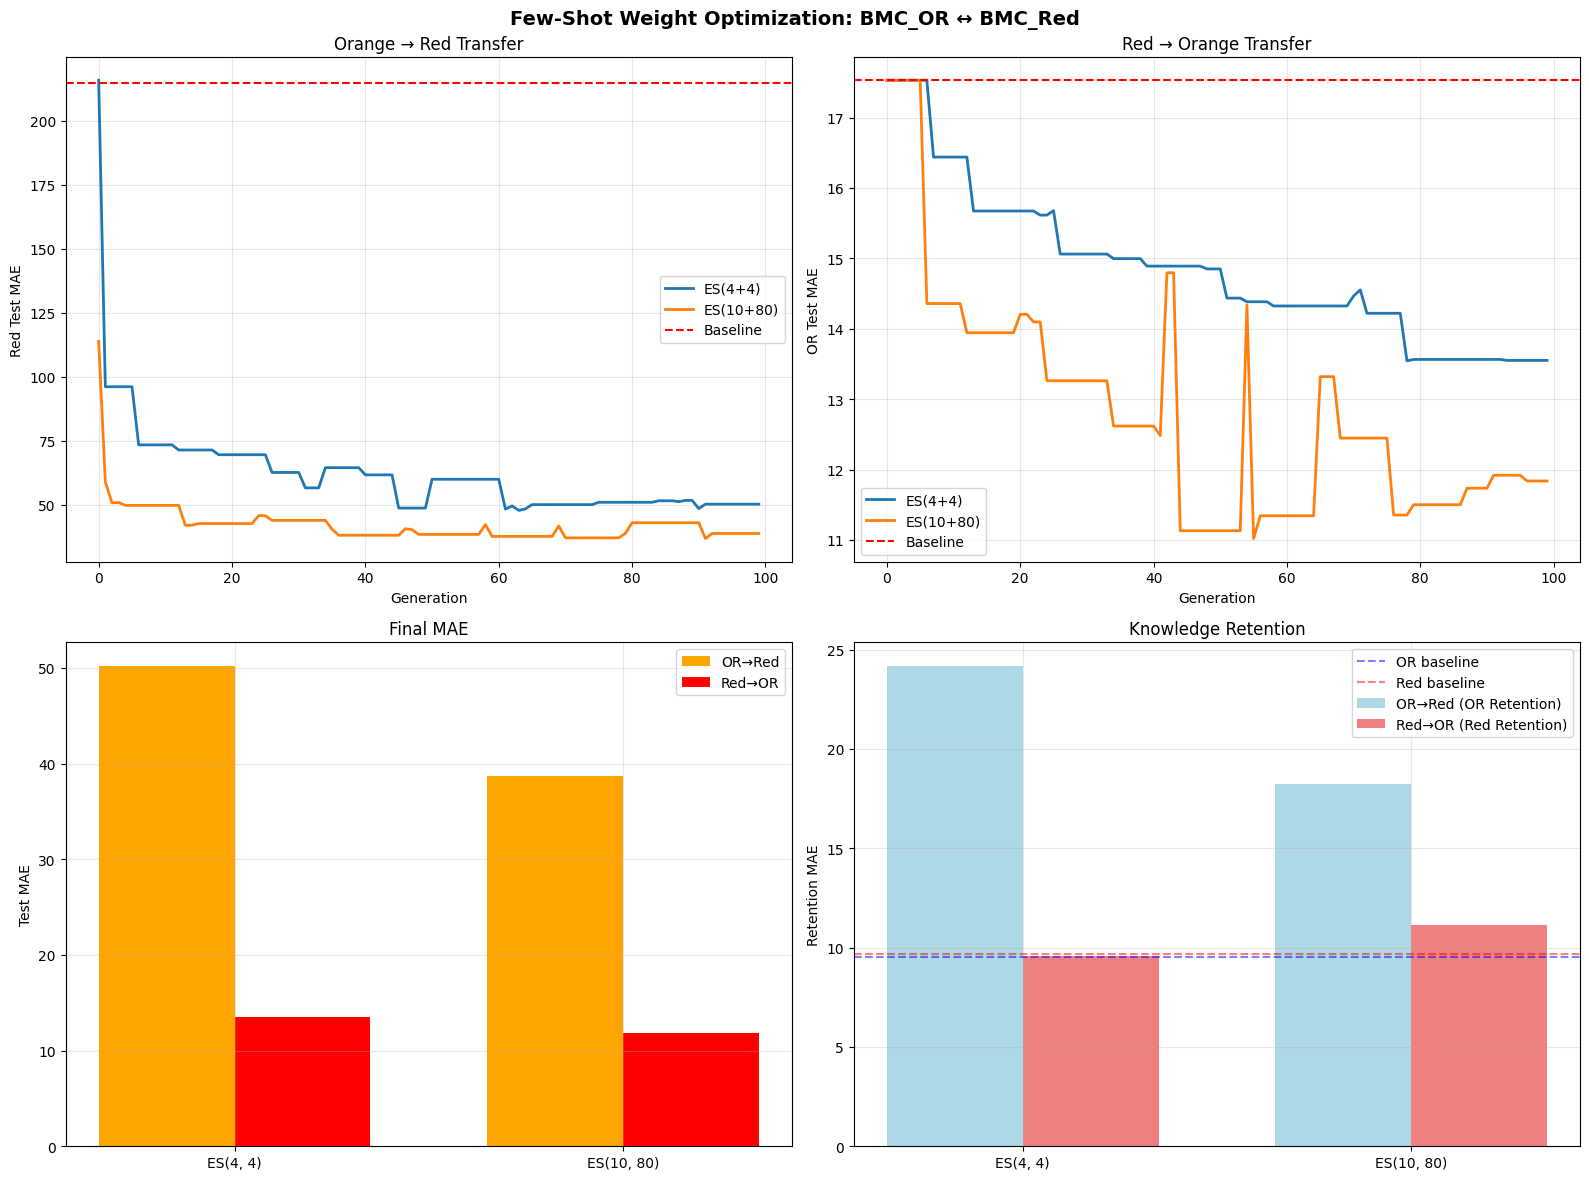

Saved: /data1/Siri/MeasuringCup/Final_codefiles/FS_results/fs_weight_optimization_results.png


In [23]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: OR → Red MAE evolution
ax1 = axes[0, 0]
for (n, m), data in or_to_red_results.items():
    h = data['history']
    ax1.plot(h['generation'], h['test_mae'], label=f'ES({n}+{m})', linewidth=2)
ax1.axhline(y=or_on_red_baseline, color='r', linestyle='--', label='Baseline')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Red Test MAE')
ax1.set_title('Orange → Red Transfer')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Red → OR MAE evolution
ax2 = axes[0, 1]
for (n, m), data in red_to_or_results.items():
    h = data['history']
    ax2.plot(h['generation'], h['test_mae'], label=f'ES({n}+{m})', linewidth=2)
ax2.axhline(y=red_on_or_baseline, color='r', linestyle='--', label='Baseline')
ax2.set_xlabel('Generation')
ax2.set_ylabel('OR Test MAE')
ax2.set_title('Red → Orange Transfer')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Final MAE comparison
ax3 = axes[1, 0]
x = np.arange(len(CONFIG['nm_pairs']))
width = 0.35
or_to_red_maes = [or_to_red_results[nm]['final_red_mae'] for nm in CONFIG['nm_pairs']]
red_to_or_maes = [red_to_or_results[nm]['final_or_mae'] for nm in CONFIG['nm_pairs']]
ax3.bar(x - width/2, or_to_red_maes, width, label='OR→Red', color='orange')
ax3.bar(x + width/2, red_to_or_maes, width, label='Red→OR', color='red')
ax3.set_ylabel('Test MAE')
ax3.set_title('Final MAE')
ax3.set_xticks(x)
ax3.set_xticklabels([f'ES{nm}' for nm in CONFIG['nm_pairs']])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Retention
ax4 = axes[1, 1]
or_retention = [or_to_red_results[nm]['retention_or_mae'] for nm in CONFIG['nm_pairs']]
red_retention = [red_to_or_results[nm]['retention_red_mae'] for nm in CONFIG['nm_pairs']]
ax4.bar(x - width/2, or_retention, width, label='OR→Red (OR Retention)', color='lightblue')
ax4.bar(x + width/2, red_retention, width, label='Red→OR (Red Retention)', color='lightcoral')
ax4.axhline(y=or_baseline_mae, color='blue', linestyle='--', alpha=0.5, label=f'OR baseline')
ax4.axhline(y=red_baseline_mae, color='red', linestyle='--', alpha=0.5, label=f'Red baseline')
ax4.set_ylabel('Retention MAE')
ax4.set_title('Knowledge Retention')
ax4.set_xticks(x)
ax4.set_xticklabels([f'ES{nm}' for nm in CONFIG['nm_pairs']])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Few-Shot Weight Optimization: BMC_OR ↔ BMC_Red', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'fs_weight_optimization_results.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {CONFIG['output_dir']}/fs_weight_optimization_results.png")

## Cell 14: Save Summary Report

In [24]:
total_time = time.time() - START_TIME
minutes = int(total_time // 60)
seconds = int(total_time % 60)

summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_time_minutes': total_time / 60,
    'baselines': {
        'or_model_on_or_test': float(or_baseline_mae),
        'red_model_on_red_test': float(red_baseline_mae),
        'or_model_on_red_test': float(or_on_red_baseline),
        'red_model_on_or_test': float(red_on_or_baseline)
    },
    'or_to_red_results': {
        str(nm): {
            'final_red_mae': float(data['final_red_mae']),
            'retention_or_mae': float(data['retention_or_mae'])
        } for nm, data in or_to_red_results.items()
    },
    'red_to_or_results': {
        str(nm): {
            'final_or_mae': float(data['final_or_mae']),
            'retention_red_mae': float(data['retention_red_mae'])
        } for nm, data in red_to_or_results.items()
    },
    'best_configs': {
        'or_to_red': str(best_or_to_red),
        'red_to_or': str(best_red_to_or)
    }
}

summary_path = os.path.join(CONFIG['output_dir'], 'fs_weight_optimization_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Saved: {summary_path}")

print("\n" + "#"*60)
print("#  FEW-SHOT WEIGHT OPTIMIZATION COMPLETE!")
print("#"*60)
print(f"#  Total Time: {minutes:02d}:{seconds:02d}")
print(f"#  Best OR→Red: ES{best_or_to_red} MAE={or_to_red_results[best_or_to_red]['final_red_mae']:.4f}")
print(f"#  Best Red→OR: ES{best_red_to_or} MAE={red_to_or_results[best_red_to_or]['final_or_mae']:.4f}")
print("#"*60)

Saved: /data1/Siri/MeasuringCup/Final_codefiles/FS_results/fs_weight_optimization_summary.json

############################################################
#  FEW-SHOT WEIGHT OPTIMIZATION COMPLETE!
############################################################
#  Total Time: 14:18
#  Best OR→Red: ES(10, 80) MAE=38.7304
#  Best Red→OR: ES(10, 80) MAE=11.8379
############################################################
